In [22]:
import pandas as pd
import numpy as np

In [23]:
# Read the CSV file
df = pd.read_csv('population-and-demography.csv')

# The first column is the country name
# The second column is the country code
# The third column is the year
# The fourth column is the population
# We need a table with rows as countries and columns as years

# Pivot the table
df = df.pivot(index='Entity', columns='Year', values='Population - Sex: all - Age: all - Variant: estimates')

df.index.names = ['Country']

# Countries-Continents.csv contains the mapping of countries to continents
ccdf = pd.read_csv('Countries-Continents.csv')


# We need to merge the two tables on the country code and add the continent as a column
df = df.reset_index()
df = df.merge(ccdf, left_on='Country', right_on='Country', how='inner')
# df = df.drop(columns=['Country'])
df = df.set_index('Country')
# Lets make Continent the first column
df = df[['Continent'] + [col for col in df.columns if col != 'Continent']]

print(df.head())

            Continent     1950     1951     1952     1953      1954      1955  \
Country                                                                         
Afghanistan      Asia  7776182  7879343  7987783  8096703   8207953   8326981   
Albania        Europe  1247854  1276364  1308369  1343582   1381087   1418855   
Algeria        Africa  9018423  9269869  9521212  9772646  10014393  10247428   
Andorra        Europe     6018     5843     5474     5346      5623      6187   
Angola         Africa  4551869  4602567  4651693  4706358   4766716   4832774   

                 1956      1957      1958  ...      2014      2015      2016  \
Country                                    ...                                 
Afghanistan   8454302   8588340   8723412  ...  32792527  33831765  34700614   
Albania       1456823   1497952   1543981  ...   2903748   2898634   2897868   
Algeria      10482183  10717503  10953641  ...  39205035  40019528  40850720   
Andorra          6788      7420 

In [24]:
# Lets filter ccdf for Africa only contries and calculate how many countries are in Africa
africa = ccdf[ccdf['Continent'] == 'Africa']
print('Number of countries in Africa:', len(africa))

# Now lets count in df how many countries are in Africa
africa_df = df[df['Continent'] == 'Africa']
print('Number of countries in Africa:', len(africa_df))

# So we have 54 in ccdf but only 50 in df. Lets find out which countries are missing
missing = africa[~africa['Country'].isin(africa_df.index)]
print('Countries missing in the population data:', missing)

# Great! I leave this cell for checking the data and the code.
# I fixed Countries-Continents.csv manually and now they match

Number of countries in Africa: 55
Number of countries in Africa: 55
Countries missing in the population data: Empty DataFrame
Columns: [Continent, Country]
Index: []


In [45]:
# We want to calculate the population growth rate for african countries
# We are looking for the growth from 2020 to 2023 in absolute numbers and in percentage

# Lets calculate the growth in absolute numbers
last_year = africa_df[2023]
first_year = africa_df[2020]
growth = last_year - first_year
# Lets calculate the growth in percentage, round to 2 decimal places
growth_percentage = ((growth / first_year) * 100).round(2)
# Lets merge the two series into a dataframe
growth = pd.concat([growth, growth_percentage], axis=1)
# Lets name the columns
growth.rename(columns={0: 'Growth', 1: 'Rate'}, inplace=True)

# Lets sort the dataframe by the growth in percentage
growth = growth.sort_values(by='Rate', ascending=False)

growth

,Growth,Rate
Country,,
Chad,2094388,12.16
Niger,2442248,10.30
Somalia,1707421,10.25
Dem. Rep. Congo,9799734,10.21
Angola,3298767,9.86
Mali,2055290,9.47
Uganda,4199455,9.45
Tanzania,5644806,9.26
Mozambique,2851480,9.26


In [40]:
import geopandas as gpd
import fiona

# Relative path to the shapefile
shapefile_path = '../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
africa = gpd.read_file(shapefile_path)

# Filter for African countries only
africa = africa[africa['CONTINENT'] == 'Africa']

# Rename specific countries to match those in your DataFrame
africa['NAME'] = africa['NAME'].replace({
    "Côte d'Ivoire": "Cote d'Ivoire",
    "eSwatini": "Eswatini",
    "Somaliland": "Somalia"
})

# Merge the GeoDataFrame with the DataFrame
africa = africa.set_index('NAME').join(growth)

# Handle missing data by filling NaN with a default color (e.g., grey)
africa['Rate'] = africa['Rate'].fillna(0)

print(africa.head())

                      featurecla  scalerank  LABELRANK  \
NAME                                                     
Tanzania         Admin-0 country          1          3   
W. Sahara        Admin-0 country          1          7   
Dem. Rep. Congo  Admin-0 country          1          2   
Somalia          Admin-0 country          1          6   
Kenya            Admin-0 country          1          2   

                                       SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
NAME                                                                        
Tanzania              United Republic of Tanzania    TZA         0      2   
W. Sahara                          Western Sahara    SAH         0      2   
Dem. Rep. Congo  Democratic Republic of the Congo    COD         0      2   
Somalia                                   Somalia    SOM         0      2   
Kenya                                       Kenya    KEN         0      2   

                              TYPE TLC               

In [30]:
nan_countries = africa[africa['Growth'].isna()]
# Display the countries with NaN in the Rate column
print(nan_countries[['geometry']])  # Displaying the countries' names and geometries

Empty GeoDataFrame
Columns: [geometry]
Index: []


/var/folders/ls/b9fnrbmn07n9ln31qsq49p3c0000gn/T/ipykernel_28314/533452687.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(africa.geometry.centroid.x, africa.geometry.centroid.y, africa['Rate']):


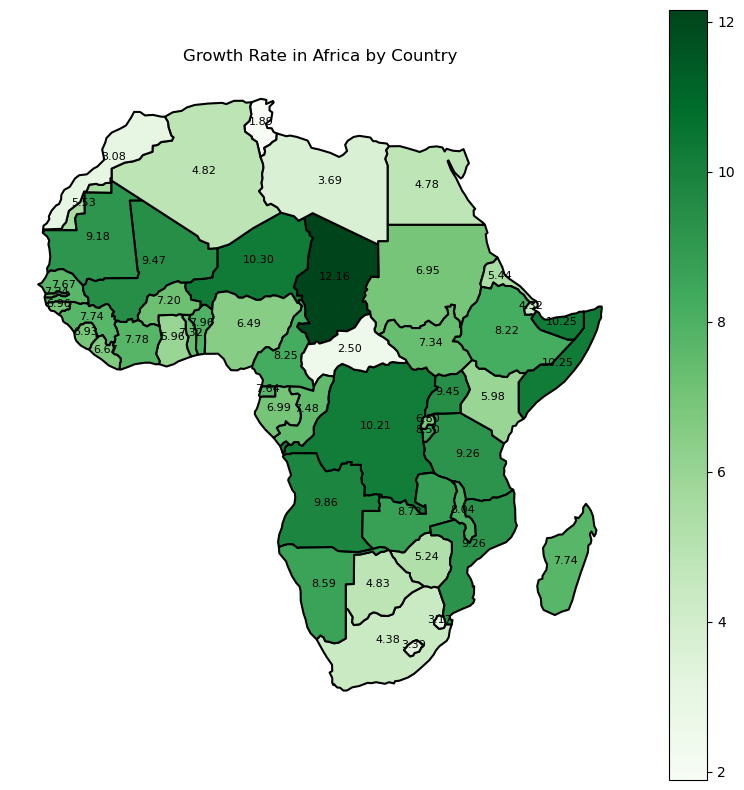

In [46]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Ensure that text is not converted to paths
mpl.rcParams['svg.fonttype'] = 'none'  # Set fonttype to 'none' to keep text as text

# Plotting the map with green color scheme and more visible borders
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
africa.plot(column='Rate', cmap='Greens', linewidth=1.5, ax=ax, edgecolor='black', legend=True)

# Add a title to the map
ax.set_title('Growth Rate in Africa by Country')

# Remove the axis borders (the black square around the map)
ax.set_axis_off()

# Add text labels for each country
for x, y, label in zip(africa.geometry.centroid.x, africa.geometry.centroid.y, africa['Rate']):
    ax.text(x, y, f'{label:.2f}', fontsize=8, ha='center', color='black')

# Save the plot as an SVG file with text saved as text
plt.savefig('africa_growth_rate_with_labels_text.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()
